In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 5 2024

@author: Yaning
Suggested by Sarah
"""
# functions for simulating agent data
# this file address is your own

%run Documents/pyro_models/files_to_run/data_analysis_without_version.ipynb
%run Documents/pyro_models/files_to_run/normal_log_model.py

import math
import os
# from turtle import position
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform, Bernoulli, Categorical, Gamma
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
# import pandas as pd
import numpy as np
import scipy.stats as stats 


['', 'trial', 'val_basic', 'delay', 'val_prc', 'response', 'RT', 'respSide', 'sideNOW', 'Version', 'loopID', 'Context']


In [3]:
test_data = data[1,0]
test_data = torch.tensor(test_data)

In [4]:
test_data[0]

tensor([ 1.0000, 20.0000, 12.2000, 38.0000,  1.0000,  2.8579,  1.0000,  1.0000],
       dtype=torch.float64)

In [5]:
actions = torch.tensor(test_data[:, 4])
delays = torch.tensor(test_data[:, 2])
ss_values = torch.tensor(test_data[:, 1])
ll_values = torch.tensor(test_data[:, 3])

/tmp/ipykernel_1020297/1533172448.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(test_data[:, 4])
/tmp/ipykernel_1020297/1533172448.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delays = torch.tensor(test_data[:, 2])
/tmp/ipykernel_1020297/1533172448.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ss_values = torch.tensor(test_data[:, 1])
/tmp/ipykernel_1020297/1533172448.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

In [ ]:
pyro.render_model(model = model_normal_log, model_args=(actions, delays, ss_values, ll_values,), render_params=True, render_distributions=True)

Mean ELBO  56.65: 100%|███████████████████████████████████████████| 400/400 [00:23<00:00, 16.87it/s]


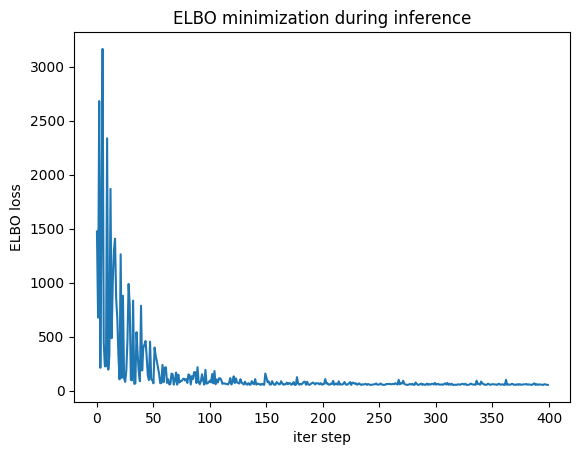

In [23]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
# the step was 2000
n_steps = 2 if smoke_test else 400

# assert pyro.__version__.startswith('1.8.6')

# clear the param store in case we're in a REPL
pyro.clear_param_store()# setup the optimizer
# the learning rate was 0.0005 , "betas": (0.90, 0.999)
# tried "n_par":15 in adam params but it does not have this argument
adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)
# setup the inference algorithm
svi = SVI(model_normal_log, guide_normal_log, optimizer, loss=Trace_ELBO())
# svi = SVI(model_gamma, guide_gamma, optimizer, loss=Trace_ELBO())

loss = []
pbar = tqdm(range(n_steps), position = 0)
# do gradient steps
for step in pbar:
    loss.append(torch.tensor(svi.step(actions, delays, ss_values, ll_values)))
    pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
    # for name, value in pyro.get_param_store().items():
    #     print(name, pyro.param(name))
    if torch.isnan(loss[-1]):
	    break

plt.figure()
plt.plot(loss)
plt.xlabel("iter step")
plt.ylabel("ELBO loss")
plt.title("ELBO minimization during inference")
plt.show()

In [24]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

mean_u_mean_q tensor(2.0369, requires_grad=True)
mean_u_sigma_q tensor(0.4781, grad_fn=<AddBackward0>)
sigma_u_mean_q tensor(1.7491, requires_grad=True)
sigma_u_sigma_q tensor(0.0522, grad_fn=<AddBackward0>)
sigma_es_mean_q tensor(1.2509, requires_grad=True)
sigma_es_sigma_q tensor(0.0764, grad_fn=<AddBackward0>)
beta_mean_q tensor(0.3072, requires_grad=True)
beta_sigma_q tensor(0.0855, grad_fn=<AddBackward0>)


In [ ]:
# only used for auto guide
# auto guide does not work too well in this model
n_samples = 1000
post_mean_u = []
post_sigma_u = []
post_sigma_es = []
for i in range(n_samples):
    sample = auto_g_normal_log()
    # print(sample)
    post_mean_u.append(sample["mean_u"].detach().item())
    post_sigma_u.append(sample["log_sigma_u"].detach().item())
    post_sigma_es.append(sample["log_sigma_es"].detach().item())